C:\Users\ericsc\AppData\Local\Temp\ipykernel_11632\1836261386.py:16: RuntimeWarning: invalid value encountered in sqrt
  return C**alpha * L**beta


Equilibrium Labor without tax: 9.596372150876737
Equilibrium Wage without tax: 10.403627849123263
Equilibrium Consumption without tax: 199.84998381954617
Equilibrium Labor with tax: 9.125419868861846
Equilibrium Wage with tax: 10.874580131138154
Equilibrium Consumption with tax: 179.40385084247788
Compensating Variation (CV): 3.547099887787936
Equivalent Variation (EV): -3.6344939092931705


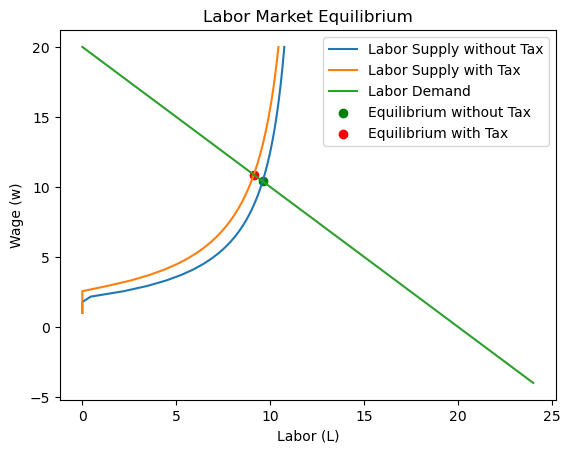

In [1]:
import numpy as np
from scipy.optimize import minimize, brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Utility function parameters
alpha = 0.5
beta = 0.5
T = 24  # Total hours in a day
y = 50  # Non-labor income
t = 0.2  # Marginal tax rate
A = 20  # Parameter for labor demand
B = 1  # Parameter for labor demand

def utility(C, L):
    return C**alpha * L**beta

def budget_no_tax(L, w, y):
    C = w * (T - L) + y
    return -utility(C, L)

def budget_with_tax(L, w, y):
    C = (1 - t) * w * (T - L) + y
    return -utility(C, L)

def labor_demand(L):
    return A - B * L

def get_labor_supply(w, budget_func, y):
    result = minimize(budget_func, x0=[T/2], args=(w, y), bounds=[(0, T)], method='L-BFGS-B')
    L_optimal = result.x[0]
    return T - L_optimal

# Reduce the number of points for faster computation
num_points = 50

wage_rates = np.linspace(1, A, num_points)
labor_supply_no_tax = np.array([get_labor_supply(w, budget_no_tax, y) for w in wage_rates])
labor_supply_with_tax = np.array([get_labor_supply(w, budget_with_tax, y) for w in wage_rates])

def find_equilibrium(labor_supply_curve):
    def equilibrium_condition(L):
        w_supply = np.interp(L, labor_supply_curve, wage_rates)
        w_demand = labor_demand(L)
        return w_supply - w_demand

    L_eq = brentq(equilibrium_condition, 0, T)
    w_eq = labor_demand(L_eq)
    return L_eq, w_eq

L_eq_no_tax, w_eq_no_tax = find_equilibrium(labor_supply_no_tax)
L_eq_with_tax, w_eq_with_tax = find_equilibrium(labor_supply_with_tax)

C_no_tax = w_eq_no_tax * (T - L_eq_no_tax) + y
U_no_tax = utility(C_no_tax, T - L_eq_no_tax)

C_with_tax = (1 - t) * w_eq_with_tax * (T - L_eq_with_tax) + y
U_with_tax = utility(C_with_tax, T - L_eq_with_tax)

def find_compensation_for_utility(target_utility, with_tax=True):
    compensation_levels = np.linspace(-50, 50, num_points)  # Adjust range for faster computation
    labor_equilibria = []

    for compensation in compensation_levels:
        if with_tax:
            modified_budget = lambda L, w, y: budget_with_tax(L, w, y + compensation)
        else:
            modified_budget = lambda L, w, y: budget_no_tax(L, w, y + compensation)

        new_labor_supply = np.array([get_labor_supply(w, modified_budget, y + compensation) for w in wage_rates])
        L_eq_new, w_eq_new = find_equilibrium(new_labor_supply)
        C_new = (1 - t) * w_eq_new * (T - L_eq_new) + y + compensation if with_tax else w_eq_new * (T - L_eq_new) + y + compensation
        U_new = utility(C_new, T - L_eq_new)
        labor_equilibria.append((U_new, compensation))

    labor_equilibria = np.array(labor_equilibria)
    labor_interpolator = interp1d(labor_equilibria[:, 0], labor_equilibria[:, 1], kind='linear', fill_value='extrapolate')
    compensation_needed = labor_interpolator(target_utility)
    return compensation_needed

cv = find_compensation_for_utility(U_no_tax, with_tax=True)
ev = find_compensation_for_utility(U_with_tax, with_tax=False)

print(f"Equilibrium Labor without tax: {L_eq_no_tax}")
print(f"Equilibrium Wage without tax: {w_eq_no_tax}")
print(f"Equilibrium Consumption without tax: {C_no_tax}")
print(f"Equilibrium Labor with tax: {L_eq_with_tax}")
print(f"Equilibrium Wage with tax: {w_eq_with_tax}")
print(f"Equilibrium Consumption with tax: {C_with_tax}")
print(f"Compensating Variation (CV): {cv}")
print(f"Equivalent Variation (EV): {ev}")

# Plotting the results
fig, ax = plt.subplots()
Ls = np.linspace(0, T, 100)
wages_demand = labor_demand(Ls)

ax.plot(labor_supply_no_tax, wage_rates, label='Labor Supply without Tax')
ax.plot(labor_supply_with_tax, wage_rates, label='Labor Supply with Tax')
ax.plot(Ls, wages_demand, label='Labor Demand')
ax.scatter([L_eq_no_tax], [w_eq_no_tax], color='green', label='Equilibrium without Tax')
ax.scatter([L_eq_with_tax], [w_eq_with_tax], color='red', label='Equilibrium with Tax')
ax.set_xlabel('Labor (L)')
ax.set_ylabel('Wage (w)')
plt.title('Labor Market Equilibrium')
plt.legend()
plt.show()